In [1]:
from scipy.interpolate import pade
#import scipy
#print(scipy.__version__)
from scipy.special import factorial
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
import math


def taylor_ex(tmu2k2):
    nk = tmu2k2.shape[0]
    
    para = np.zeros(nk)
    for i in range(nk):
        para[i] = (-1)**i
    para /= factorial( 2*np.arange(nk) )
    # print(para)
    a2k = para * tmu2k2
    # print(a2k)
        
    taylor = np.zeros(2*nk-1)
    for i in range(nk):
        taylor[2*i] = a2k[i]
    # print(taylor)
    
    return taylor

#p00 = np.array([1, 1, 1, 1, 3.6]) 

infc = np.inf
bounds = ([-infc,-infc,0,0,0], +infc)
    
def fitfun(t, a1, gamma1, a2, gamma2, w2,funcname):
    if funcname == "gaussian":
        def f(x):
            return np.exp(-x**2)
    elif funcname == "hyperbolic":
        def f(x):
            return 1/np.cosh(x) 
    elif funcname == "lorentzian":
        def f(x):
            return 1/(x**2+1)

    return a1 * f(gamma1*t) + a2*f(gamma2*t)*np.cos(w2*t)
    
def fitfun_hyperbolic(t, a1, gamma1, a2, gamma2, w2):
    funcname = "hyperbolic"
    return fitfun(t, a1, gamma1, a2, gamma2, w2, funcname) 


def fitfun_gaussian(t, a1, gamma1, a2, gamma2, w2,):
    funcname = "gaussian"
    return fitfun(t, a1, gamma1, a2, gamma2, w2, funcname) 

def fitfun_lorentzian(t, a1, gamma1, a2, gamma2, w2):
    funcname = "lorentzian"
    return fitfun(t, a1, gamma1, a2, gamma2, w2, funcname) 

def fft_to_2tsigma(w, a1, gamma1, a2, gamma2, w2,funcname):
    if funcname == "gaussian":
        def f(w, ww, gamma):
            return np.exp(-1/4/(gamma**2)*(w+ww)**2) + np.exp(-1/4/(gamma**2)*(w-ww)**2)
        def part(w, a, gamma, ww):
            return a/2.0*math.pow(np.pi,0.5)/gamma*f(w, ww, gamma)
        return part(w,a1,gamma1,0) + part(w,a2,gamma2,w2) 
    elif funcname == "hyperbolic":
        def f(w, ww, gamma):
            return 1./np.cosh(np.pi/2*(w+ww)/gamma) + 1./np.cosh(np.pi/2*(w-ww)/gamma) 
        def part(w, a, gamma, ww):
            return a/2.0*np.pi/gamma*f(w, ww, gamma)
        return part(w,a1,gamma1,0) + part(w,a2,gamma2,w2) 
    elif funcname == "lorentzian":
        def f(w, ww, gamma):
            return np.exp(-abs(w+ww)/gamma)+np.exp(-abs(w-ww)/gamma)
        def part(w, a, gamma, ww):
            return a/2.0*np.pi/gamma*f(w, ww, gamma)
        return part(w,a1,gamma1,0) + part(w,a2,gamma2,w2) 

def Mii(mu):
    n = mu.size
    Mij = np.zeros([n,n])
    for i in range(n):
        Mij[i,0] = mu[i]/mu[0]
        Mij[i,1] = mu[i]/mu[0]
        
    for j in range(2,n,1):
        for i in range(n):
            if Mij[j-1,j-1] ==0:
                a = 10e-3
            else:
                a =  Mij[j-1,j-1]          
            if Mij[j-2,j-2] ==0:
                b =10e-3
            else:
                b = Mij[j-2,j-2]
            Mij[i,j] = Mij[i,j-1]/a - Mij[i-1,j-2]/b
                 
    return np.diag(Mij)

def denomitor(w, Mii, i=1):
    if i==Mii.size-1:
        return math.sqrt(Mii[i])
    else:
        d = denomitor(w, Mii, i+1)
        # print(i," ",d)
        return  complex(0,1)*w + Mii[i]/d

def tsigma(w, tmu0, Mii):
    d = denomitor(w, Mii)
    # print(d)
    return  tmu0*2/denomitor(w, Mii)

In [2]:
def summary(jj,order,bound,p00):
    taylor = taylor_ex(jj)
    orders = np.array([(4,4),(4,6),(6,6),(6,8),order])



    for order in orders:
        order1, order2 = order
        p,q = pade(taylor,order2,order1)

        x = np.arange(0,5,0.01)
        y = p(x)/q(x)
        plt.plot(x, y, label = f"pade[{order1}/{order2}]" ) 
    plt.plot(x, np.zeros(x.shape[0]), "k--")

    plt.legend(loc='upper right')
    #plt.ylim(0.8,1)
    plt.show()

    ##############################
    t = np.arange(0,bound,0.01)
    y = p(t)/q(t)

    plt.plot(t, y ,label=f"pade[{order1}/{order2}]")
    p00 = p001 #np.array([0.5, 2.5, 0.5,2.3, 0.5]) 
    popt1, pcov = curve_fit(fitfun_hyperbolic, t, y, p0=p00,maxfev = 12000, 
                           bounds=([0,0,0,0,0],[np.inf,np.inf,np.inf,np.inf,np.inf]))
    print(popt1)
    plt.plot(t, fitfun_hyperbolic(t, *popt1),label='hyperbolic')


#     t = np.arange(0,bound,0.01)
#     y = p(t)/q(t)
#     p00 = p001  #np.array([0.5, 2.5, 0.5,2.3, 0.5]) 
#     popt, pcov = curve_fit(fitfun_gaussian, t, y, p0 = p00,maxfev = 12000,  
#                            bounds=([0,0,0,0,0],[np.inf,np.inf,np.inf,np.inf,np.inf]))
#     print(popt)
#     plt.plot(t, fitfun_gaussian(t, *popt),label='gaussian')

#     t = np.arange(0,bound,0.01)
#     y = p(t)/q(t)
#     p00 = p001  #np.array([0.5, 2.5, 0.5,2.3, 0.5]) 
#     popt, pcov = curve_fit(fitfun_lorentzian, t, y, p0 = p00,maxfev = 12000,  
#                            bounds=([0,0,0,0,0],[np.inf,np.inf,np.inf,np.inf,np.inf]))
#     print(popt)
#     plt.plot(t, fitfun_lorentzian(t, *popt),label='lorentzian')


    plt.legend(loc='upper right')

    plt.show()
    ##############################

    ts = np.arange(0,bound,0.01)
    ys = p(ts)/q(ts)
    p00 = p001 #np.array([0.5, 2.5, 0.5,2.3, 0.5]) 
    popt, pcov = curve_fit(fitfun_hyperbolic, ts, ys,p0 =p00,maxfev = 12000,  
                           bounds=([0,0,0,0,0],[np.inf,np.inf,np.inf,np.inf,np.inf]))
    ws = np.arange(0,10,0.01)
    sigma2t = np.zeros(ws.size)
    for i, w in enumerate(ws):
        sigma2t[i] = fft_to_2tsigma(w,*popt,"hyperbolic")    
    plt.plot(ws, sigma2t/2, label = "hyperbolic")
    print(sigma2t[0]/2)

    ts = np.arange(0,bound,0.01)
    ys = p(ts)/q(ts)
    p00 = p001 #np.array([0.5, 2.5, 0.5,2.3, 0.5]) 
    popt, pcov = curve_fit(fitfun_gaussian, ts, ys,p0 =p00,maxfev = 12000,  
                           bounds=([0,0,0,0,0],[np.inf,np.inf,np.inf,np.inf,np.inf]))
    ws = np.arange(0,10,0.01)
    sigma2t = np.zeros(ws.size)
    for i, w in enumerate(ws):
        sigma2t[i] = fft_to_2tsigma(w,*popt,"gaussian")    
    plt.plot(ws, sigma2t/2, label = "gaussian")
    print(sigma2t[0]/2)

    ts = np.arange(0,bound,0.01)
    ys = p(ts)/q(ts)
    p00 = p001 #np.array([0.5, 2.5, 0.5,2.3, 0.5]) 
    popt, pcov = curve_fit(fitfun_lorentzian, ts, ys,p0 =p00,maxfev = 12000,  
                          bounds=([0,0,0,0,0],[np.inf,np.inf,np.inf,np.inf,np.inf]))
    ws = np.arange(0,10,0.01)
    sigma2t = np.zeros(ws.size)
    for i, w in enumerate(ws):
        sigma2t[i] = fft_to_2tsigma(w,*popt,"lorentzian")    
    plt.plot(ws, sigma2t/2, label = "lorentzian")
    print(sigma2t[0]/2)

    plt.legend()
    plt.show()

   
    
    
    return popt1

for U=8; n=0.5
jj


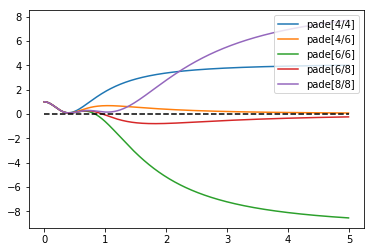

[0.57876662 2.60961321 0.42223263 2.40944595 7.83896716]


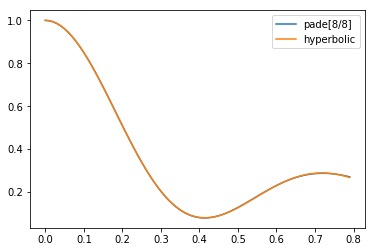

0.35169654607646084
0.37943026239665995
0.4121851693472803


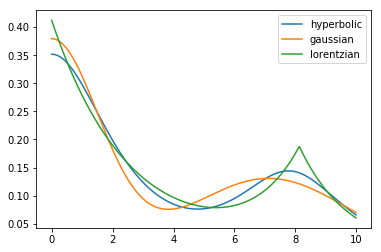

jeje


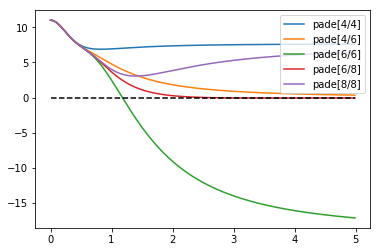

[10.29929389  1.65970497  0.70279425  2.52206246  7.52966585]


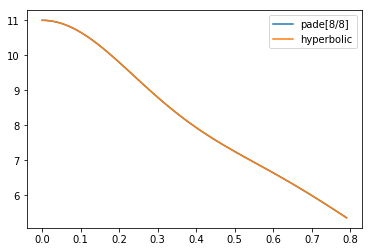

9.755616126239463
8.996709263576642
12.82162140391088


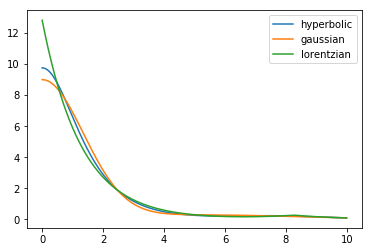

jkjk


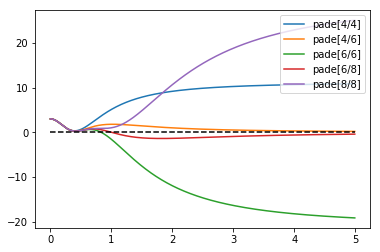

[1.54771054 2.13277952 1.45925046 2.815125   7.39822428]


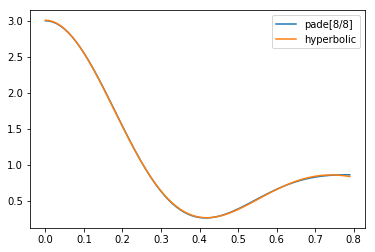

1.166125616694621
1.4886043085802059
1.3388947970624325


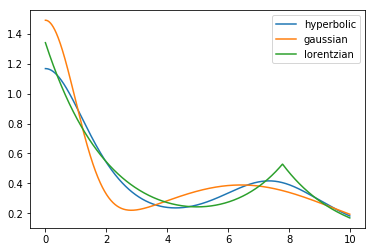

jpjp


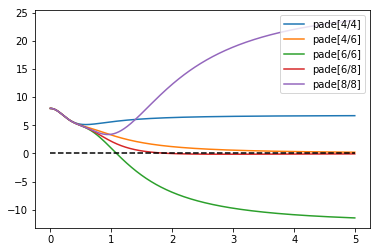

[7.14322822 1.67701608 0.86512531 3.49605006 7.1826922 ]


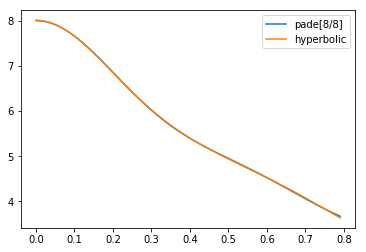

6.721575993390724
6.303767136017278
8.693742330986971


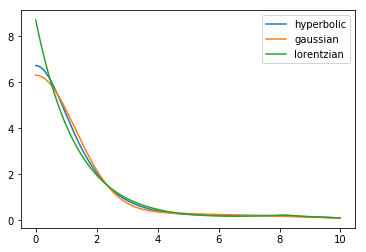

In [26]:
print("for U=8; n=0.5")
U=8

jj = 4*np.array([0.25000000000000000000,
8.00000000000000000000,
648.00000000000000000000,
70272.00000000000000000000,
9622696.00000000000000000000,
1652019456.00000000000000000000,
357113156736.00000000000000000000,
97459664165376.00000000000000000000,
33131781921228776.00000000000000000000])

jeje = 4*np.array([2.75000000000000000000,
18.00000000000000000000,
1024.00000000000000000000,
104842.00000000000000000000,
14631456.00000000000000000000,
2745152800.00000000000000000000,
697145064064.00000000000000000000,
231714094395066.00000000000000000000,
94576109187604864.00000000000000000000])

jkjk = 4*np.array([0.75000000000000000000,
24.00000000000000000000,
1984.00000000000000000000,
221512.00000000000000000000,
30816192.00000000000000000000,
5182087936.00000000000000000000,
1043001147904.00000000000000000000,
252720820237608.00000000000000000000,
74654307899332160.00000000000000000000])

jpjp = 4*np.array([2.00000000000000000000,
18.00000000000000000000,
1312.00000000000000000000,
159946.00000000000000000000,
25179456.00000000000000000000,
4932302368.00000000000000000000,
1207245841792.00000000000000000000,
370007879172666.00000000000000000000,
139220351843875520.00000000000000000000])



p001 = np.array([0.5,2,0.5,3,8])
p002 = np.array([1,2,2,2,8])
p003 = np.array([0.5,2,0.5,3,8])
p004 = np.array([1,2,2,2,8])
print("jj")
jjresult= summary(jj,(8,8),0.8,p001)
print("jeje")
jejeresult= summary(jeje,(8,8),0.8,p002)
print("jkjk")
jkjkresult= summary(jkjk,(8,8),0.8,p003)
print("jpjp")
jpjpresult= summary(jpjp,(8,8),0.8,p004)

In [28]:
print(jejeresult)
print(jkjkresult)
print(jpjpresult)
print(jjresult)

[10.29929389  1.65970497  0.70279425  2.52206246  7.52966585]
[1.54771054 2.13277952 1.45925046 2.815125   7.39822428]
[7.14322822 1.67701608 0.86512531 3.49605006 7.1826922 ]
[0.57876662 2.60961321 0.42223263 2.40944595 7.83896716]


for U=10; n=0.5
jj


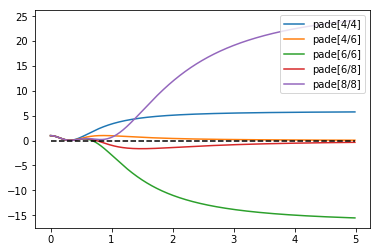

[0.51462873 2.22314143 0.49042076 2.75796738 9.64601229]


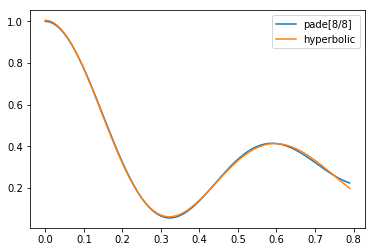

0.3659162192880398
0.3484052283646924
0.4593038893013244


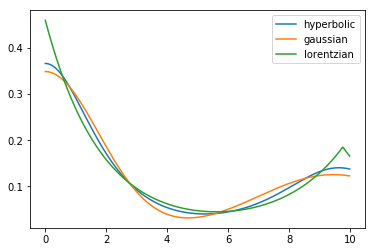

jeje


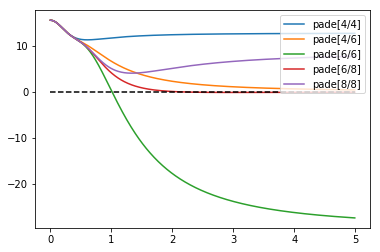

[14.8261721   1.71718916  0.67460844  2.32736473  9.84938442]


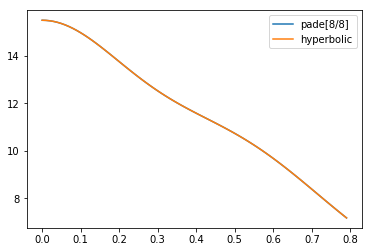

13.563400944705304
12.019473729212585
18.159839305085548


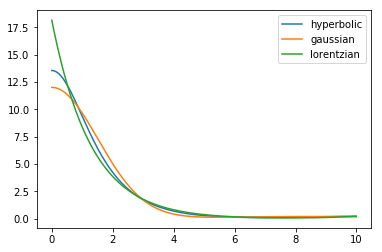

jkjk


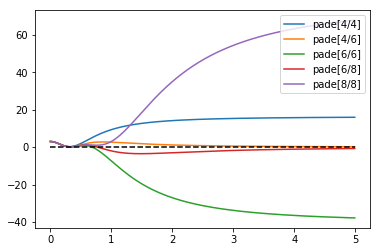

[1.31747399 1.44345834 1.7119892  3.5075027  8.9977311 ]


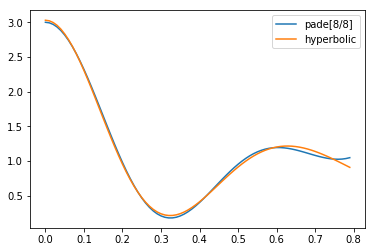

1.4609570433500647
1.5407609425608824
1.7391158534619826


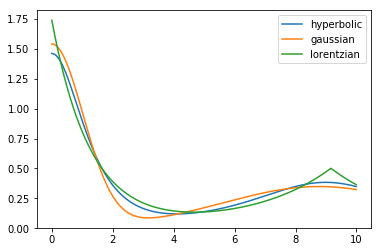

jpjp


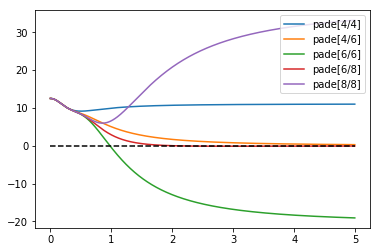

[11.39950271  1.62057132  1.13037967  5.05565532  7.83970699]


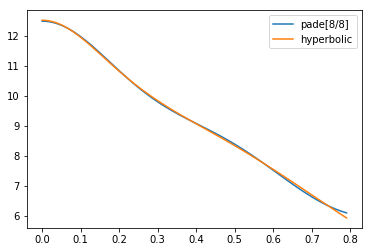

11.11038656814381
10.045084657402086
14.579335137174205


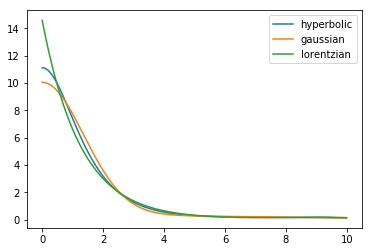

In [3]:
print("for U=10; n=0.5")
U=10

jj = 4*np.array([0.25000000000000000000,
12.50000000000000000000,
1462.50000000000000000000,
210600.00000000000000000000,
35934812.50000000000000000000,
7322156737.50000000000000000000,
1828526367450.00000000000000000000,
579554846619900.00000000000000000000,
236872827357786496.00000000000000000000,])

jeje = 4*np.array([3.87500000000000000000,
28.12500000000000000000,
2275.00000000000000000000,
315803.12500000000000000000,
56236434.37500000000000000000,
13154841025.00000000000000000000,
4239328526575.00000000000000000000,
1842221950235370.50000000000000000000,
993291684680534144.00000000000000000000])

jkjk = 4*np.array([0.75000000000000000000,
37.50000000000000000000,
4450.00000000000000000000,
658412.50000000000000000000,
115159237.50000000000000000000,
23477454400.00000000000000000000,
5596471315600.00000000000000000000,
1594528953292629.50000000000000000000,
561801194360549056.00000000000000000000])

jpjp = 4*np.array([3.12500000000000000000,
28.12500000000000000000,
2725.00000000000000000000,
436328.12500000000000000000,
87176184.37500000000000000000,
21432744175.00000000000000000000,
6671528903950.00000000000000000000,
2668969884120693.00000000000000000000,
1332349404320605184.00000000000000000000,])



p001 = np.array([0.5,2,0.5,3,10])
p002 = np.array([1,2,2,2,10])
p003 = np.array([0.5,2,0.5,3,10])
p004 = np.array([1,2,2,2,10])
print("jj")
jjresult= summary(jj,(8,8),0.8,p001)
print("jeje")
jejeresult= summary(jeje,(8,8),0.8,p002)
print("jkjk")
jkjkresult= summary(jkjk,(8,8),0.8,p003)
print("jpjp")
jpjpresult= summary(jpjp,(8,8),0.8,p004)

In [4]:
print(jejeresult)
print(jkjkresult)
print(jpjpresult)
print(jjresult)

[14.8261721   1.71718916  0.67460844  2.32736473  9.84938442]
[1.31747399 1.44345834 1.7119892  3.5075027  8.9977311 ]
[11.39950271  1.62057132  1.13037967  5.05565532  7.83970699]
[0.51462873 2.22314143 0.49042076 2.75796738 9.64601229]


for U=12; n=0.5
jj


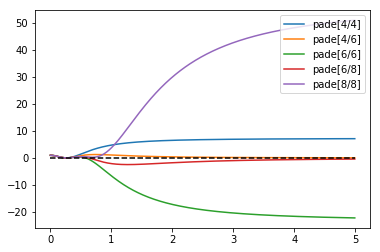

[ 0.49025725  1.92838443  0.51834164  3.05669995 11.58622783]


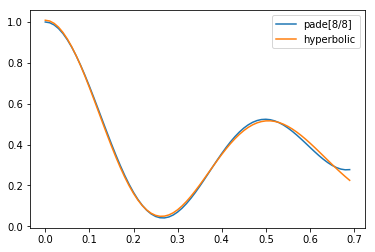

0.4007295431343011
0.3612164737114934
0.5231500440080893


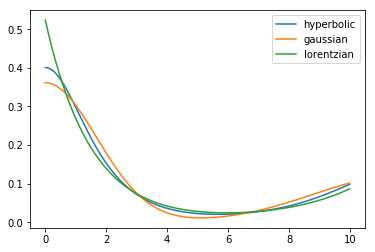

jeje


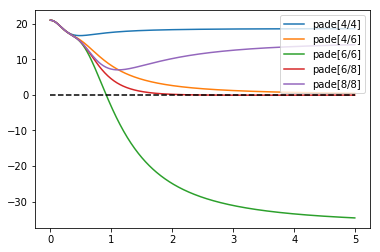

[20.33593801  1.74236131  0.65963667  1.94304469 12.05335075]


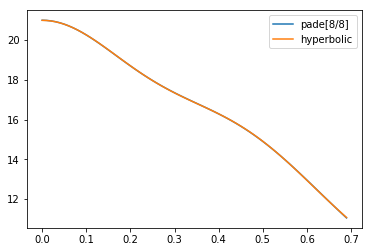

18.333582974922717
15.829017673005875
24.888311750475964


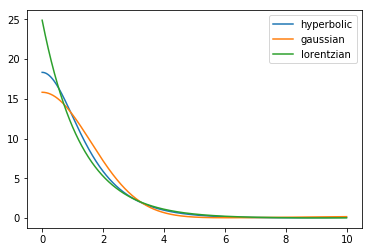

jkjk


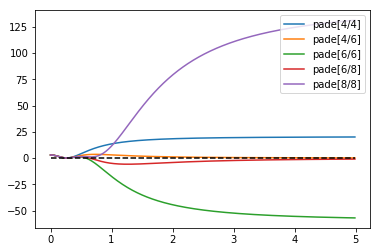

[ 1.34025954  1.32287417  1.6971954   3.71341665 11.13808106]


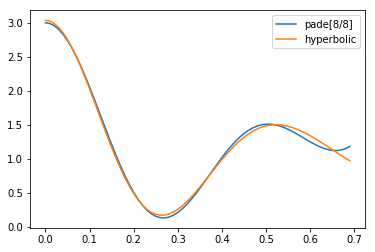

1.6043493400700959
1.5148673133805477
2.0159129004426446


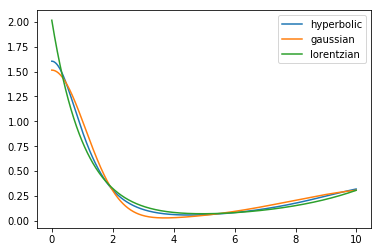

jpjp


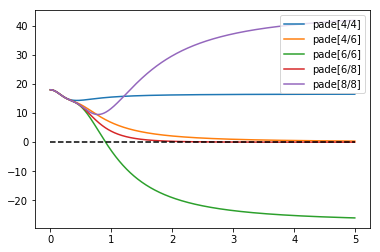

[17.09195275  1.69278934  0.93716919  4.77464182 10.82835289]


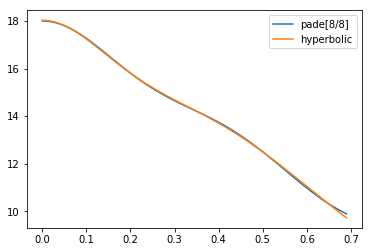

15.87767989814692
13.959137679265506
21.359051201230734


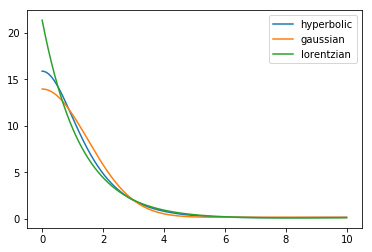

In [7]:
print("for U=12; n=0.5")
U=12

jj = 4*np.array([0.25000000000000000000,
18.00000000000000000000,
2898.00000000000000000000,
544032.00000000000000000000,
115837146.00000000000000000000,
28277356536.00000000000000000000,
8172880407936.00000000000000000000,
2956208936957856.00000000000000000000,
1407170553730180608.00000000000000000000,
])

jeje = 4*np.array([5.25000000000000000000,
40.50000000000000000000,
4464.00000000000000000000,
817294.50000000000000000000,
182820726.00000000000000000000,
52285446000.00000000000000000000,
20759736926664.00000000000000000000,
11429154891536082.00000000000000000000,
7915503189346575360.00000000000000000000,])

jkjk = 4*np.array([0.75000000000000000000,
54.00000000000000000000,
8784.00000000000000000000,
1687842.00000000000000000000,
368920872.00000000000000000000,
91156634496.00000000000000000000,
25685436943584.00000000000000000000,
8511542427261614.00000000000000000000,
3496336265557749760.00000000000000000000])

jpjp = 4*np.array([4.50000000000000000000,
40.50000000000000000000,
5112.00000000000000000000,
1051438.50000000000000000000,
261374526.00000000000000000000,
78920638848.00000000000000000000,
30458402476632.00000000000000000000,
15481924189548382.00000000000000000000,
9978976756896620544.00000000000000000000])



p001 = np.array([0.5,2,0.5,3,12])
p002 = np.array([1,2,2,2,12])
p003 = np.array([0.5,2,0.5,3,12])
p004 = np.array([1,2,2,2,12])
print("jj")
jjresult= summary(jj,(8,8),0.7,p001)
print("jeje")
jejeresult= summary(jeje,(8,8),0.7,p002)
print("jkjk")
jkjkresult= summary(jkjk,(8,8),0.7,p003)
print("jpjp")
jpjpresult= summary(jpjp,(8,8),0.7,p004)

In [8]:
print(jejeresult)
print(jkjkresult)
print(jpjpresult)
print(jjresult)

[20.33593801  1.74236131  0.65963667  1.94304469 12.05335075]
[ 1.34025954  1.32287417  1.6971954   3.71341665 11.13808106]
[17.09195275  1.69278934  0.93716919  4.77464182 10.82835289]
[ 0.49025725  1.92838443  0.51834164  3.05669995 11.58622783]
